# COMPAS 

## Abstract
COMPAS er en algoritme utvikla for å anslå hvor trolig det er at en sikta person vil begå nye straffbare handlinger, og brukes utbredt i amerikansk rettvesen. Da nettavisen ProPublica i 2016 tok for seg ulike deler av algoritmen, synes det gjennomgående at algoritmen på bakgrunn av etnisitet ga hvite et lavere risikoanslag enn svarte. Vi skal i denne analysen ta for oss ulike deler av algoritmen og reprodusere resultatene til ProPublica. I den tilhørende etiske rapporten diskuterer vi behovet og det etiske grunnlaget for en slik algoritme.

## Datasettet

ProPublica hentet data om insatte i Broward County, Florida, USA, og gjorde sin analyse av COMPAS basert på denne dataen. ProPublica har gjort dette datasettet fritt tilgjenglig, og det er det vi bruker i vår analyse.

Vi omformer kolonnene i datasettet noe, og ender med følgende kolonner som er relevante for vår analyse:
 - Kolonnen `sex` gir kjønnet til personen
 - Kolonnen `white` indikerer om personen er "hvit" eller ikke, hvor vi definerer hvit som gruppen ("race") "Caucasian" i det originale datasettet
 - Kolonnen `score` gir scoren som COMPAS ga personen
 - Kolonnen `predicted` indikerer om COMPAS predikerte personen til å begå nye lovbrudd
 - Kolonnen `actual` indikerer om personen faktisk begikk nye lovbrudd
 
Vi har valgt å se på "hvite" og "ikke hvite" for å unngå problematikk med rest-grupper som ville oppstått ved fordeling i "hvite" og "svarte". En annen mulig inndeling kunne vært "svart" og "ikke-svart".

In [1]:
import pandas as pd
import matplotlib.ticker as mtick
from IPython.core.display import display, HTML

def display_df_pct(df):
    display(HTML(df.to_html(float_format=lambda x: f'{x*100:.1f}%')))

data = pd.read_csv("../data/compas-scores-two-years.csv")
data = data[data["days_b_screening_arrest"] <= 30]
data = data[data["days_b_screening_arrest"] >= -30]
df = pd.DataFrame({ 
    "sex": data.sex,
    "white": data.race == "Caucasian",
    "score": data.decile_score,
    "predicted": data.score_text != "Low",
    "actual": data.is_recid == 1
})
df

,sex,white,score,predicted,actual
0,Male,False,1,False,False
1,Male,False,3,False,True
2,Male,False,4,False,True
5,Male,False,1,False,False
6,Male,True,6,True,True
...,...,...,...,...,...
7209,Male,False,7,True,False
7210,Male,False,3,False,False
7211,Male,False,1,False,False
7212,Female,False,2,False,False


## Predikerte og faktisk gjentatte forbrytelser

Vi lager firefeltstabeller for å se på hvor ofte ulike grupperinger (kvinner/menn og hvite/ikke-hvite) blir predikert å gjenta forbrytelser og faktisk gjør det.

In [2]:
def get_relative_frequency(group, target):
    group_size = len(df[group])
    target_size = len(df[group & target])
    rel_freq = target_size/group_size
    return f'{rel_freq*100:.1f}%'

def four_field_table(group, group_name, rest_name):
    return pd.DataFrame({
        "Predikert": [get_relative_frequency(group, df.predicted), get_relative_frequency(~group, df.predicted)],
        "Faktisk": [get_relative_frequency(group, df.actual), get_relative_frequency(~group, df.actual)],
    }, index = [group_name, rest_name])

### Predikerte og faktisk gjentatte forbrytelser etter hudfarge

In [3]:
four_field_table(df.white, "Hvite", "Ikke-hvite")

,Predikert,Faktisk
Hvite,33.1%,41.6%
Ikke-hvite,50.5%,52.0%


### Predikerte og faktisk gjentatte forbrytelser etter kjønn

In [4]:
four_field_table(df.sex == 'Male', "Menn", "Kvinner")

,Predikert,Faktisk
Menn,45.5%,51.1%
Kvinner,40.5%,37.0%


Fra tallene ser vi at det blant hvite er 8 prosentpoeng færre som blir predikert å begå nye lovbrudd enn som faktisk gjør det.
Det tilsvarende tallet for ikke-hvite er kun 2 prosentpoeng.
For menn er det 6 prosentpoeng, og for kvinner -4 prosentpoeng.

Dette tyder på en "overprediksjon" for kvinner og betraktelig større "underprediksjon" for hvite enn ikke-hvite.

## Risiko for gjentatte forbrytelser

COMPAS gir en score fra 1 til 10 for at hver gjerningspersonen i en sak vil begå nye lovbrudd. Vi ser på fordelingen av denne scoren i forskjellige grupper.

In [5]:
def plot_score_dist(df, title, group, group_name, rest_name, all_name = 'Alle'):
    ax = pd.DataFrame({
        all_name: df.score.value_counts(normalize = True),
        group_name: df[group].score.value_counts(normalize = True),
        rest_name: df[~group].score.value_counts(normalize = True)
    }).sort_index().plot.bar(title = title, style = {all_name: "k--"})
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))


### Fordeling av score etter hudfarge

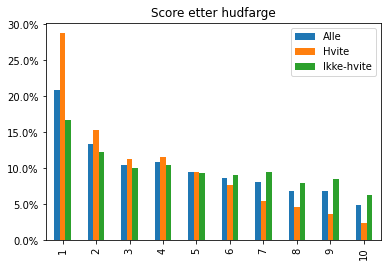

In [6]:
plot_score_dist(df, "Score etter hudfarge", df.white, "Hvite", "Ikke-hvite")

Ser at de hvite stolpene har en tilnærmet eksponesiell hellning mot venstre, der de lave risiko-scorene er (mer log-fordelt). I venstre del av grafen er de ikke-hvite stolpene konsekvent lavere enn snittet, i høyre del er det motsatt. Dette betyr at en større andel av de ikke-hvite får høye scorer, enn blandt de hvite.

### Fordeling av score etter kjønn

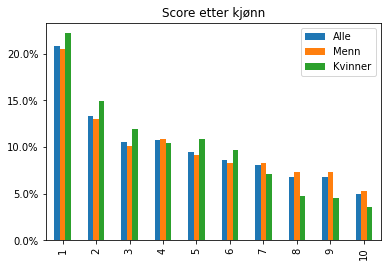

In [7]:
plot_score_dist(df, "Score etter kjønn", df.sex == 'Male', "Menn", "Kvinner")

For menn og kvinner ser vi ingen tydelig forskjell i grafene.

### Fordeling av score etter gjentatt forbrytelse

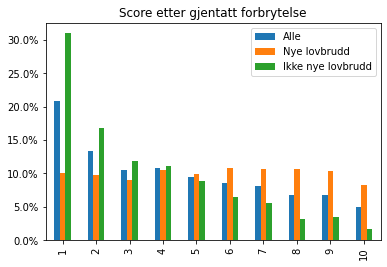

In [8]:
plot_score_dist(df, "Score etter gjentatt forbrytelse", df.actual, "Nye lovbrudd", "Ikke nye lovbrudd")

Vi ser, som ønsket, en avtagende trend for personer som ikke gjorde nye lovbrudd, men blant personer som gjorde nye lovbrudd er trenden flat.

### Fordeling av score etter gjentatte forbrytelser, hvite

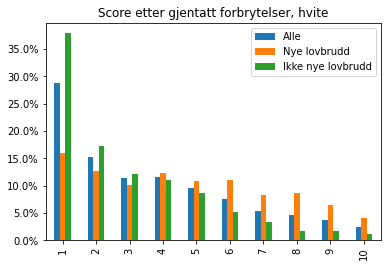

In [9]:
df_white = df[df.white]
plot_score_dist(df_white, "Score etter gjentatt forbrytelser, hvite", df_white.actual, "Nye lovbrudd", "Ikke nye lovbrudd")

### Fordeling av score etter gjentatte forbrytelser, ikke-hvite

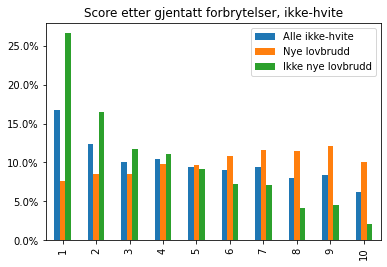

In [10]:
df_non_white = df[~df.white]
plot_score_dist(df_non_white, "Score etter gjentatt forbrytelser, ikke-hvite", df_non_white.actual, "Nye lovbrudd", "Ikke nye lovbrudd", "Alle ikke-hvite")

Vi ser, som ønsket, at en stor andel av de som ikke begikk nye lovbrudd fikk lav risiko-score. Men der score-grafen dipper nedover for høyere scorer for hvite som gjorde nye lovbrudd, går den oppover blant de ikke-hvite.

## Betinget sannsynlighet
Positiv prediktiv verdi er sannsynligheten for at en person som ble predikert å begå nye lovbrudd faktisk begikk nye lovbrudd. Sensitivitet er det "motsatte": sannsynligheten for at en person som faktisk begikk nye lovbrudd ble predikert å gjøre det.

De to sannsynligheten er relatert med Bayes setning.  

In [11]:
def conditional_prob(df):
    a = pd.DataFrame({
        "Ikke gjentatt": df[~df.actual].predicted.value_counts().sort_index(),
        "Gjentatt lovbrudd": df[df.actual].predicted.value_counts().sort_index()
    }).rename({False: "Ikke predikert", True: "Predikert"}) / len(df)
    display_df_pct(a)
    pos_pred = a["Gjentatt lovbrudd"]["Predikert"] / a.loc["Predikert"].sum()
    print(f"Pos. pred. verdi: {pos_pred*100:.1f}%")
    sens = a["Gjentatt lovbrudd"]["Predikert"] / a["Gjentatt lovbrudd"].sum()
    print(f"    Sensitivitet: {sens*100:.1f}%")

### Alle

In [12]:
conditional_prob(df)

,Ikke gjentatt,Gjentatt lovbrudd
Ikke predikert,36.4%,19.0%
Predikert,15.1%,29.4%


Pos. pred. verdi: 66.0%
    Sensitivitet: 60.8%


### Hvite

In [13]:
conditional_prob(df[df.white])

,Ikke gjentatt,Gjentatt lovbrudd
Ikke predikert,45.8%,21.1%
Predikert,12.6%,20.4%


Pos. pred. verdi: 61.8%
    Sensitivitet: 49.2%


### Ikke hvite

In [14]:
conditional_prob(df[~df.white])

,Ikke gjentatt,Gjentatt lovbrudd
Ikke predikert,31.6%,17.9%
Predikert,16.4%,34.1%


Pos. pred. verdi: 67.5%
    Sensitivitet: 65.5%


### Menn

In [15]:
conditional_prob(df[df.sex == 'Male'])

,Ikke gjentatt,Gjentatt lovbrudd
Ikke predikert,34.6%,19.9%
Predikert,14.3%,31.2%


Pos. pred. verdi: 68.6%
    Sensitivitet: 61.1%


### Kvinner

In [16]:
conditional_prob(df[df.sex == 'Female'])

,Ikke gjentatt,Gjentatt lovbrudd
Ikke predikert,44.3%,15.2%
Predikert,18.7%,21.8%


Pos. pred. verdi: 53.8%
    Sensitivitet: 58.9%


Interessant blant disse tallene er at sensitiviteten blant hvite (49,2%) er mye lavere enn blant ikke-hvite (65,5%). Dette betyr at flere hvite som begikk nye lovbrudd ikke ble predikert å skulle gjøre det enn svarte.
Det er også verdt å merke at kvinner har betraktelig lavere positiv prediktiv verdi (53,8%) enn alle (66%), som betyr at flere kvinner som ble predikert å begå nye lovbrudd ikke endte med å gjøre det, enn de andre gruppene.

# Predikere prediksjonen

Vi trener en logistisk modell for å se hvilken vekt som blir tilegnet predikatoren som indikerer "African-American".

In [17]:
from sklearn.linear_model import LogisticRegression
import numpy as np

categorical_cols = ["age_cat", "race", "sex", "c_charge_degree"]
X = data[["age_cat", "race", "sex", "priors_count", "c_charge_degree", "two_year_recid"]]
X = pd.get_dummies(X, columns=categorical_cols, prefix=categorical_cols, prefix_sep='_')
X = X.drop(["age_cat_25 - 45", "race_Caucasian", "sex_Male", "c_charge_degree_F"], axis=1)

Y = data["score_text"] != "Low"

model = LogisticRegression(max_iter=1000)
model.fit(X, Y)

print(model.coef_)
print(model.intercept_)

[[ 0.26841574  0.68318404 -1.34534445  1.30150177  0.47767854 -0.20805671
  -0.42133031  0.8956289  -0.80592196  0.2188144  -0.30988952]]
[-1.52332792]


Med alle vektene og bias, kalkulerer vi bias mot "African-American" som gruppe, ved å sammenlikne en idealisert person som kun har egenskapen å være "African-American" mot en person som ikke har noen egenskaper.

In [18]:
black_coef = model.coef_[0, list(X.columns).index('race_African-American')]
intercept = model.intercept_[0]

control = 1/(1+np.exp(-intercept))
racialBias = np.exp(black_coef) / (1 + control * (np.exp(black_coef) - 1))
racialBias

1.453084453051661

Tallet forteller oss at det å være "African-American" gir en 45% større sjanse for å bli predikert å begå nye lovbrudd, enn en 

In [19]:
print(X.columns)

Index(['priors_count', 'two_year_recid', 'age_cat_Greater than 45',
       'age_cat_Less than 25', 'race_African-American', 'race_Asian',
       'race_Hispanic', 'race_Native American', 'race_Other', 'sex_Female',
       'c_charge_degree_M'],
      dtype='object')


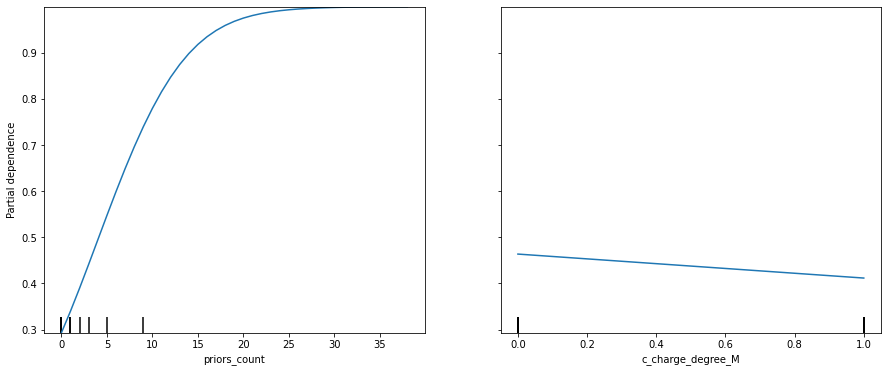

In [20]:
from sklearn.inspection import plot_partial_dependence
import matplotlib.pyplot as plt
features = ["priors_count", "c_charge_degree_M"]
plot_partial_dependence(model, X, features)
plt.gcf().set_size_inches(15, 6)
plt.show()

Observerer hvordan scorens avhengighet av priors_count økter eksponsielt. 

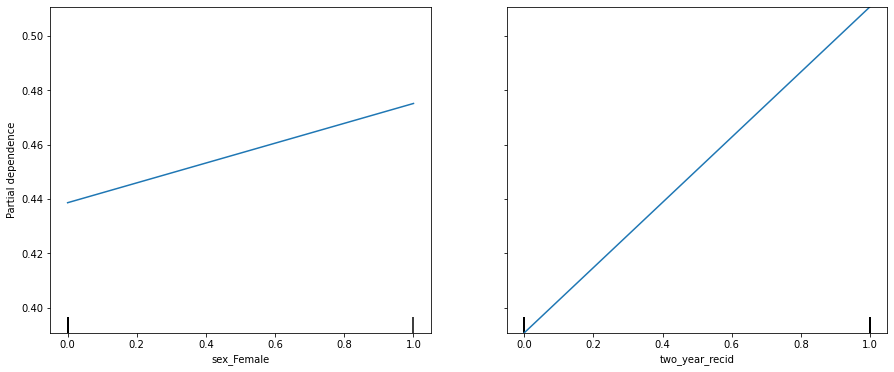

In [21]:
features = ["sex_Female", "two_year_recid"]
plot_partial_dependence(model, X, features)
plt.gcf().set_size_inches(15, 6)